<img align="left" src="./logo.png" width=300>

# `Phaser`: BCDI Phase retrieval with Python

## Created by: Siddharth Maddali
### Argonne National Laboratory
<a href="https://doi.org/10.5281/zenodo.4305131" style="float: left;"><img src="https://zenodo.org/badge/DOI/10.5281/zenodo.4305131.svg" alt="DOI"></a>

# BCDI phase retrieval with partial coherence correction (PCC)

In [1]:
import collections
import time
import warnings
import os
os.environ[ 'TF_CPP_MIN_LOG_LEVEL' ] = '3' 

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import tensorflow as tf


from argparse import Namespace
from matplotlib.colors import LogNorm
from scipy.ndimage.filters import gaussian_filter
from scipy.spatial.transform import Rotation
from scipy.ndimage.measurements import label
from scipy.ndimage import binary_erosion, binary_dilation

try: 
    from pyfftw.interfaces.numpy_fft import fftshift, fftn, ifftn
except:
    from numpy.fft import fftshift, fftn, ifftn

import Phaser as phsr
import TilePlot as tp

In [2]:
%matplotlib inline

In [3]:
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

## Recipe tips
For phasing with PCC, it's better to start the recipe with short bursts of interleaved ER + PCC. 
This is to ensure that both the object and the blurring kernel are quickly brought into the neighborhood of the correct solution, earlier than later. 
This particular recipe has the following breakdown: 

   * Wave 1: 10 ER followed by 10 PCC (1 shrinkwrap in between the ER section).
   * Wave 2: Longer stretches of ER and PCC. 
   * Wave 3: Even longer stretches of ER (200) with shrinkwrap in between. 
   * Wave 4: Final stretch of ER (200 iterations). 

In [4]:
wave_1 = '+'.join( [ 'ER:5+SR:%.2f:0.1+ER:5+PCC:10'%sig for sig in np.linspace( 3., 1., 20 ) ] ) # support should have converged pretty well by now
wave_2 = '+'.join( [ 'ER:50+SR:1.0:0.1+ER:50+PCC:200' ] * 5 )
wave_3 = '+'.join( [ 'ER:50+SR:1.0:0.1' ] * 5 )
wave_4 = 'ER:200'
recipe = '+'.join( [ wave_1, wave_2, wave_3, wave_4 ] )
print( recipe )

ER:5+SR:3.00:0.1+ER:5+PCC:10+ER:5+SR:2.89:0.1+ER:5+PCC:10+ER:5+SR:2.79:0.1+ER:5+PCC:10+ER:5+SR:2.68:0.1+ER:5+PCC:10+ER:5+SR:2.58:0.1+ER:5+PCC:10+ER:5+SR:2.47:0.1+ER:5+PCC:10+ER:5+SR:2.37:0.1+ER:5+PCC:10+ER:5+SR:2.26:0.1+ER:5+PCC:10+ER:5+SR:2.16:0.1+ER:5+PCC:10+ER:5+SR:2.05:0.1+ER:5+PCC:10+ER:5+SR:1.95:0.1+ER:5+PCC:10+ER:5+SR:1.84:0.1+ER:5+PCC:10+ER:5+SR:1.74:0.1+ER:5+PCC:10+ER:5+SR:1.63:0.1+ER:5+PCC:10+ER:5+SR:1.53:0.1+ER:5+PCC:10+ER:5+SR:1.42:0.1+ER:5+PCC:10+ER:5+SR:1.32:0.1+ER:5+PCC:10+ER:5+SR:1.21:0.1+ER:5+PCC:10+ER:5+SR:1.11:0.1+ER:5+PCC:10+ER:5+SR:1.00:0.1+ER:5+PCC:10+ER:50+SR:1.0:0.1+ER:50+PCC:200+ER:50+SR:1.0:0.1+ER:50+PCC:200+ER:50+SR:1.0:0.1+ER:50+PCC:200+ER:50+SR:1.0:0.1+ER:50+PCC:200+ER:50+SR:1.0:0.1+ER:50+PCC:200+ER:50+SR:1.0:0.1+ER:50+SR:1.0:0.1+ER:50+SR:1.0:0.1+ER:50+SR:1.0:0.1+ER:50+SR:1.0:0.1+ER:200


## Data load
The provided data file `data.mat` also contains a digital object named `crystal_4`, which will be used for the PCC demonstration.

In [5]:
mydata = Namespace( **sio.loadmat( 'data.mat' ) )

Text(0.5, 1.0, 'Partially coherent\nsignal')

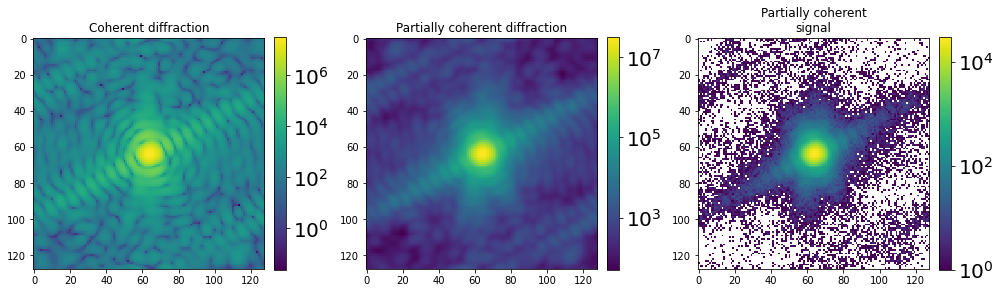

In [6]:
ax = tp.TilePlot( 
    tuple( this[:,:,35] for this in ( mydata.intens_coherent, mydata.intens_partcoh, mydata.signal ) ), 
    ( 1, 3 ), 
    ( 14, 5 ), 
    log_norm=True
)[-1]
ax[0].set_title( 'Coherent diffraction' )
ax[1].set_title( 'Partially coherent diffraction' )
ax[2].set_title( 'Partially coherent\nsignal' )

Designing the initial support for the phasing + PCC recipe as the [Patterson function](https://en.wikipedia.org/wiki/Patterson_function) of the signal. 

In [7]:
temp = np.log10( np.absolute( fftshift( fftn( fftshift( np.sqrt( mydata.signal ) ) ) ) ) )
mask = ( temp > 0.575*temp.max() ).astype( float )

In [8]:
labeled, features = label( mask )

In [9]:
support_label = list( dict( sorted( collections.Counter( labeled.ravel() ).items(), key=lambda item: -item[1] ) ).keys() )[1]
support = np.zeros( mask.shape )
support[ np.where( labeled==support_label ) ] = 1.
support = binary_erosion( binary_dilation( support, iterations=5 ), iterations=1 )

Text(0.5, 1.0, 'Estimated initial support')

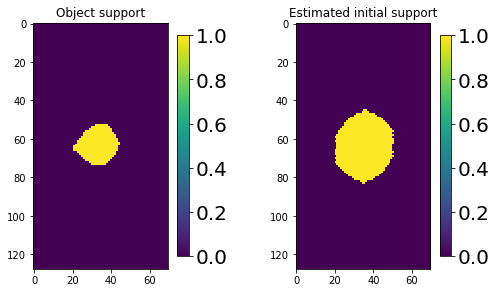

In [10]:
ax = tp.TilePlot( 
    tuple( this[64,:,:] for this in ( np.absolute( mydata.crystal_4 ), support ) ), 
    ( 1, 2 ), 
    ( 8, 4 )
)[-1] 

ax[0].set_title( 'Object support' )
ax[1].set_title( 'Estimated initial support' )

In [11]:
print( 'Simulation box size = ', support.shape )
print( 'Estiamted support bounding box = ', tuple( this.max()-this.min() for this in np.where( support > 0.5 ) ) )
print( 'Actual support bounding box = ', tuple( this.max()-this.min() for this in np.where( np.absolute( mydata.crystal_4 ) > 0.5 ) ) )

Simulation box size =  (128, 128, 70)
Estiamted support bounding box =  (40, 38, 32)
Actual support bounding box =  (25, 23, 26)


Now initializing the Phaser object on the GPU with the `pcc` flag.

In [12]:
solver = phsr.Phaser( modulus=np.sqrt( mydata.signal ), support=support, pcc=True, gpu=True ).gpusolver

In [13]:
tstart = time.time()
solver.runRecipe( recipe, show_progress=False )
tstop = time.time()

print( 'Time taken = %.2f seconds. '%( tstop - tstart ) )

Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().
Time taken = 30.41 seconds. 


In [14]:
solver.Retrieve()

In [15]:
img = solver.finalImage
sup = solver.finalSupport
C = solver.getCovarianceMatrix()

## Results

### Amplitude and phase

Text(0.5, 0.98, 'Reconstructed object')

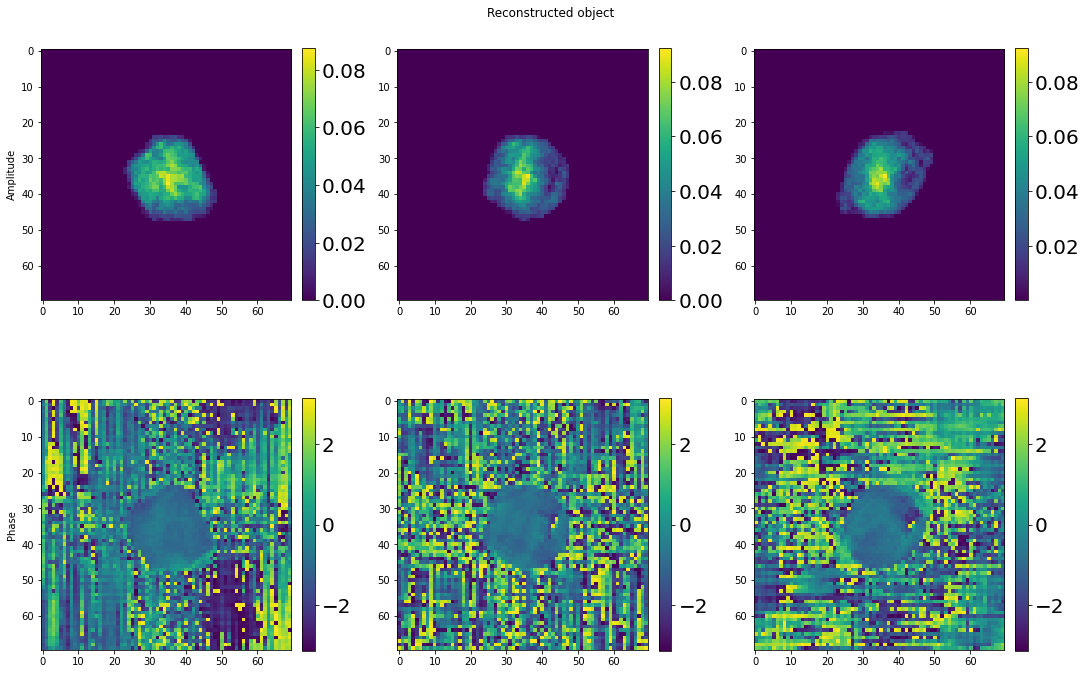

In [16]:
fig, im, ax = tp.TilePlot( 
    ( 
        np.absolute( img[29:99,29:99,35] ), np.absolute( img[ 29:99,64,:] ), np.absolute( img[64,29:99,:] ), 
        np.angle( img[29:99,29:99,35] ), np.angle( img[ 29:99,64,:] ), np.angle( img[64,29:99,:] ), 
    ), 
    ( 2, 3 ), 
    ( 15, 10 )
);
ax[0].set_ylabel( 'Amplitude' )
ax[3].set_ylabel( 'Phase' )
fig.suptitle( 'Reconstructed object' )

### Support

Text(0.5, 0.98, 'Original object')

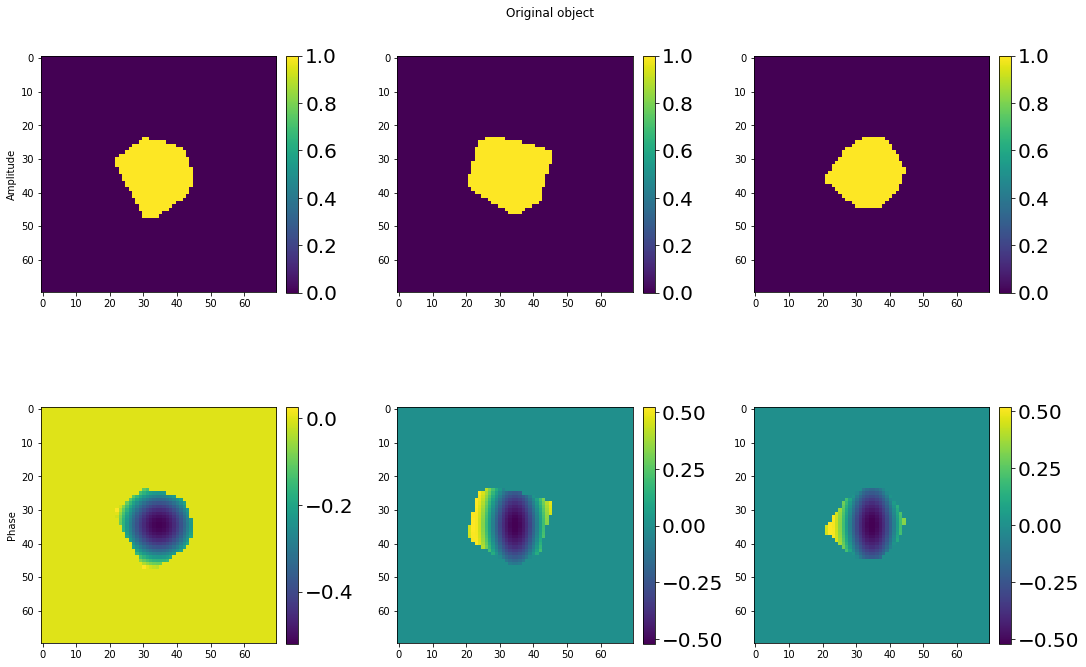

In [17]:
fig, im, ax = tp.TilePlot( 
    ( 
        np.absolute( mydata.crystal_4[29:99,29:99,35] ), np.absolute( mydata.crystal_4[ 29:99,64,:] ), np.absolute( mydata.crystal_4[64,29:99,:] ), 
        np.angle( mydata.crystal_4[29:99,29:99,35] ), np.angle( mydata.crystal_4[ 29:99,64,:] ), np.angle( mydata.crystal_4[64,29:99,:] ), 
    ), 
    ( 2, 3 ), 
    ( 15, 10 )
);
ax[0].set_ylabel( 'Amplitude' )
ax[3].set_ylabel( 'Phase' )
fig.suptitle( 'Original object' )

### Blurring kernel

In [18]:
el, ev = np.linalg.eig( C )
print( np.sqrt( el ) ) # compare with original values in the input file. 

[0.57866121 0.89249992 0.79200844]


### Error

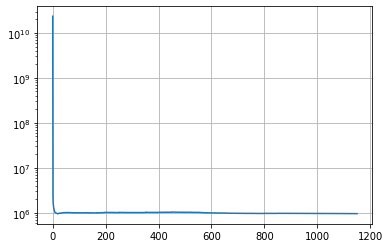

In [19]:
plt.figure()
plt.semilogy( solver._error )
plt.grid()


## Genetic algorithms with PCC
**Coming up**: How to get better PCC reconstructions with parallelized genetic algorithms.
<!--
As seen above, a single run of the solver with PCC doesn't always guarantee good results even with a well thought-out recipe. 
Shown below is the GPU-enhanced, parallelized PCC phasing suited to run on a high-performance computing system. 
The
-->